In [1]:
from utils import load_dataset_tensorflow,plot_accuraccy_loss
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50V2


2024-07-08 01:08:26.716537: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 01:08:26.720994: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 01:08:26.737988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 01:08:26.775873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 01:08:26.775935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 01:08:26.815609: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
train_base_dataset, valid_base_dataset = load_dataset_tensorflow(subset="both",validation_split=0.2)
train_aug_dataset, valid_aug_dataset = load_dataset_tensorflow(os.path.join("data","augmented","images"),subset="both",validation_split=0.2)

Found 1650 files belonging to 5 classes.
Using 1320 files for training.
Using 330 files for validation.
Found 1420 files belonging to 5 classes.
Using 1136 files for training.
Using 284 files for validation.


In [3]:

train_ds = train_base_dataset.concatenate(train_aug_dataset)
valid_ds = valid_base_dataset.concatenate(valid_aug_dataset)

def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale image to RGB
    return image, label

train_ds = train_ds.map(convert_to_rgb)
valid_ds = valid_ds.map(convert_to_rgb)

In [4]:
def get_classifier(model_base, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = model_base(inputs,training=False)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32,activation="linear")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(5,activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model


In [5]:
base_model = ResNet50V2(include_top=False)
base_model.trainable=False

In [6]:
model = get_classifier(base_model,(256,256,3))

In [7]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     4,194,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,759,301 (105.89 MB)

 Trainable params: 4,194,501 (16.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [10]:
check_callback = tf.keras.callbacks.ModelCheckpoint("models/callbacks/{epoch:02d}-{val_accuracy:.2f}.keras",verbose=0,save_best_only=True)

history = model.fit(valid_ds,epochs=20,validation_data=valid_ds,callbacks=[check_callback])

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 284s 15s/step - accuracy: 0.2668 - loss: 3841.4744 - val_accuracy: 0.3322 - val_loss: 1735.1836
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 320s 15s/step - accuracy: 0.3010 - loss: 2214.2148 - val_accuracy: 0.3339 - val_loss: 1188.7944
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 10s/step - accuracy: 0.3967 - loss: 1427.9783 - val_accuracy: 0.4919 - val_loss: 608.9596
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - accuracy: 0.4050 - loss: 1184.5094 - val_accuracy: 0.3518 - val_loss: 1135.9337
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 8s/step - accuracy: 0.3717 - loss: 1431.8254 - val_accuracy: 0.4414 - val_loss: 923.4741
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.3946 - loss: 1161.7217 - val_accuracy: 0.4935 - val_loss: 802.8472
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 204s 8s/step - accuracy: 0.4862 - loss: 1061.6895 - val_accuracy: 0.5358 - val_loss: 470.6491
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - accuracy: 0.4802 

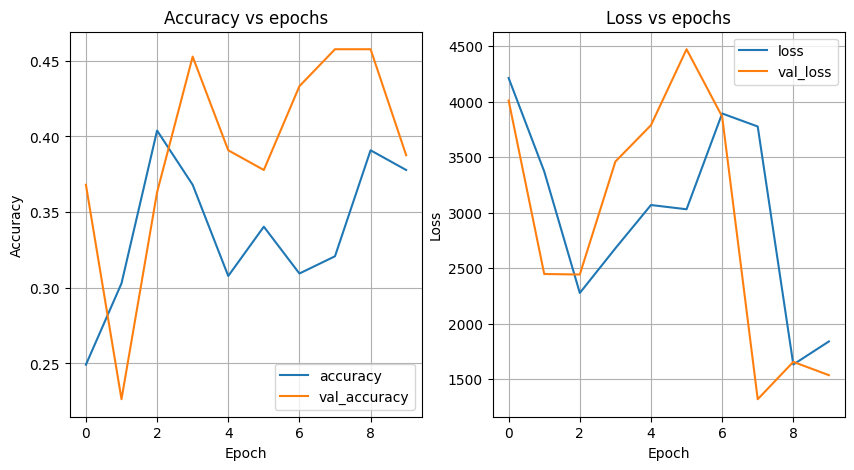

In [ ]:
plot_accuraccy_loss(history)